https://keras.io/examples/vision/captcha_ocr/

Simple ocr : cnn + rnn + ctc

processed_bmp

In [58]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from PIL import Image,  ImageOps

In [30]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# root ='/content/gdrive/My Drive/datasets'
root ='./data/data'

In [59]:
data_dir = Path("data/processed_bmp")

In [60]:
images = sorted(list(map(str, list(data_dir.glob("*.bmp")))))

In [61]:
file = open('data/processed_bmp/bmp_labels', encoding='utf-8')
labels = [l.strip().rjust(15) for l in file.readlines()]

In [62]:
data_dir = Path("data/processed_BW_Words")
_images =  sorted(list(map(str, list(data_dir.glob("*.jpg")))))

In [63]:
file = open('data/BW_word_labels.txt', encoding='utf-8')
lines = file.readlines()

In [64]:
dt ={}
for l in lines:
    f = l.split('\t')
    dt[f[0].strip()] = f[1].strip()
    

In [65]:
for i in _images:
    base=os.path.basename(i)
    name = os.path.splitext(base)[0]
    labels.append(dt[name].rjust(15))
    images.append(i)

In [66]:
characters = set(char for label in labels for char in label)

In [67]:
print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))

Number of images found:  84989
Number of labels found:  84989
Number of unique characters:  39


In [68]:
batch_size = 16

In [69]:
img_width = 128
img_height = 64

In [70]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [71]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

In [72]:
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

In [73]:
def generator(x ,y):
    
    for img_path , label in zip(x,y):

 
        img = Image.open(img_path.decode("utf-8")).convert('L').resize((img_width,img_height))
        
        img = np.asarray(img,dtype='float32')
        img = img / 255.0
        img = img.reshape((img_height, img_width,1))
        img = tf.convert_to_tensor(img, dtype=tf.float32)
        
        label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
        
        yield {"image": img, "label": label}

In [74]:
train_dataset = tf.data.Dataset.from_generator(generator, args=[x_train, y_train],
                                               output_types={'image':tf.float32, 'label':tf.int64})
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.repeat()

In [75]:
validation_dataset = tf.data.Dataset.from_generator(generator, args=[x_valid, y_valid],
                                                    output_types={'image':tf.float32, 'label':tf.int64})
validation_dataset = validation_dataset.batch(batch_size)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.repeat()

             نه


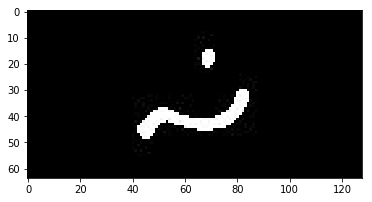

            آقا


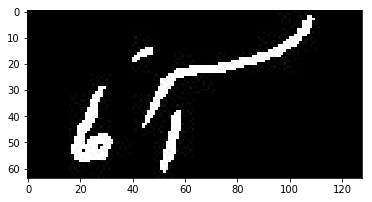

         رایانه


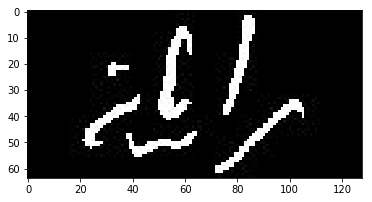

           برزن


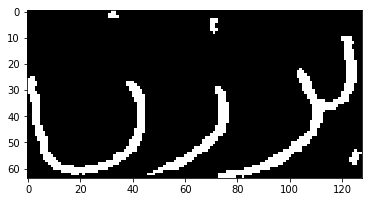

         حداکثر


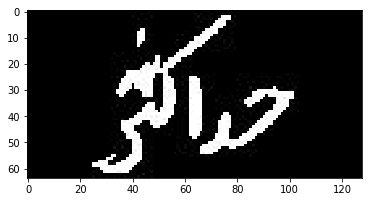

          هجدهم


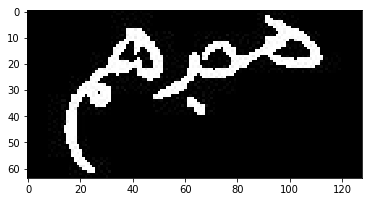

         فريدون


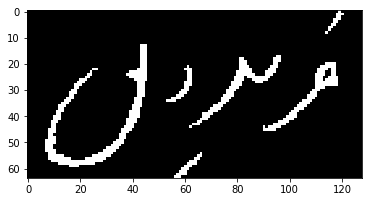

           هجری


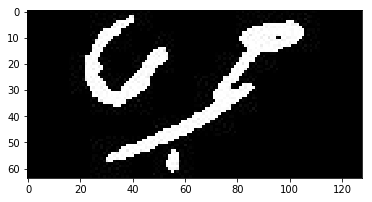

            هشت


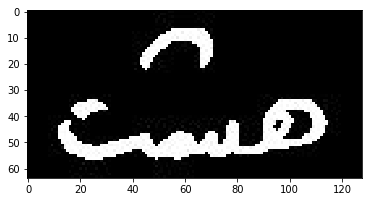

          تومان


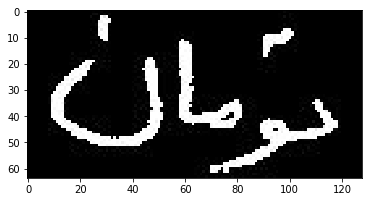

           آرام


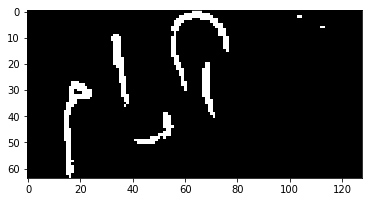

          چهارم


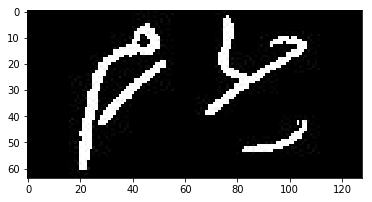

         موبایل


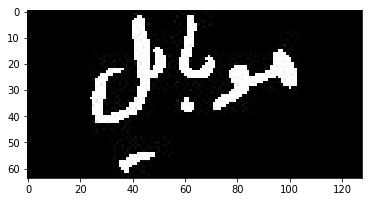

           هجری


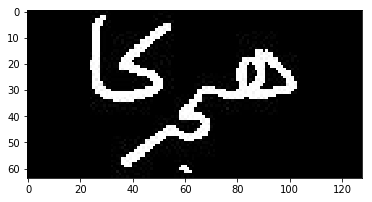

          داوود


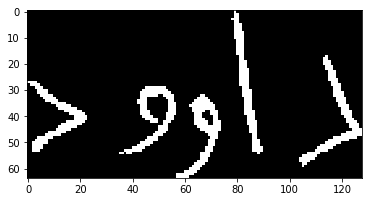

          هجدهم


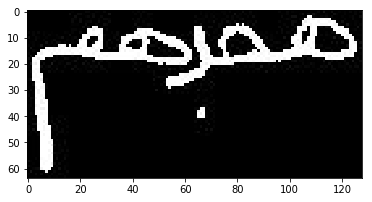

In [76]:
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        print(label)
        plt.imshow(img[:, :, 0], cmap="gray")
        plt.show()


In [77]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_height ,img_width,  1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()


Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 64, 128, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 128, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 32, 64, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 32, 64, 64)   18496       pool1[0][0]                      
_______________________________________________________________________________________

In [93]:
epochs = 50
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch = len(x_train)//batch_size ,
    validation_data=validation_dataset,
    validation_steps = len(x_valid)//batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
)


Epoch 1/50
4780/4780 [==============================] - 1309s 274ms/step - loss: 0.9739 - val_loss: 1.3448
Epoch 2/50
4780/4780 [==============================] - 1265s 265ms/step - loss: 0.9943 - val_loss: 1.3802
Epoch 3/50
4780/4780 [==============================] - 1230s 257ms/step - loss: 0.9687 - val_loss: 1.4167
Epoch 4/50
4780/4780 [==============================] - 1229s 257ms/step - loss: 0.9669 - val_loss: 1.4279
Epoch 5/50
4780/4780 [==============================] - 1227s 257ms/step - loss: 0.9401 - val_loss: 1.3356
Epoch 6/50
4780/4780 [==============================] - 1226s 257ms/step - loss: 0.9386 - val_loss: 1.4195
Epoch 7/50
4780/4780 [==============================] - 1224s 256ms/step - loss: 0.9650 - val_loss: 1.3529
Epoch 8/50
4780/4780 [==============================] - 1225s 256ms/step - loss: 0.9633 - val_loss: 1.4000
Epoch 9/50
4780/4780 [==============================] - 1232s 258ms/step - loss: 0.9067 - val_loss: 1.3550
Epoch 10/50
4780/4780 [==============

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 64, 128, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 64, 128, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 64, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 64, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 16, 32, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 1024)          0         
_________________________________________________________________
dense1 (Dense)               (None, 32, 64)            6560

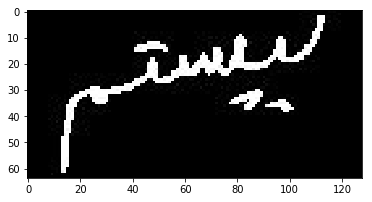

Prediction:          مینیمم


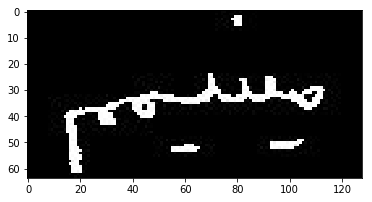

Prediction:         ماکزیمم


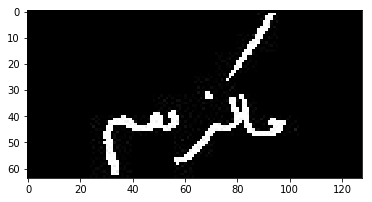

Prediction:           نوزده


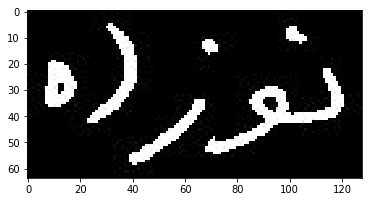

Prediction:              نه


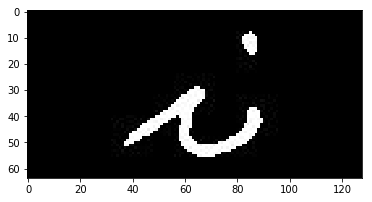

Prediction:            هزار


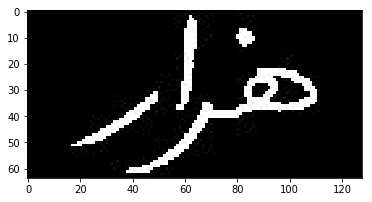

Prediction:             صفر


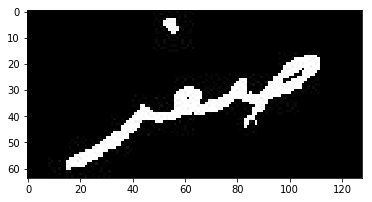

Prediction:            هزار


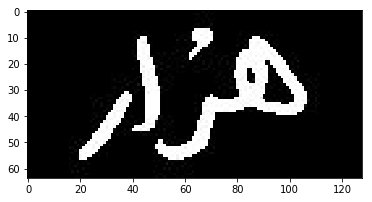

Prediction:         دوازدهم


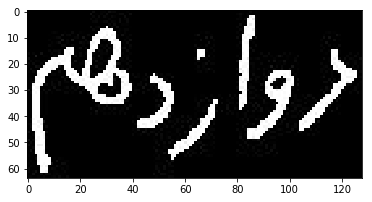

Prediction:          شانزده


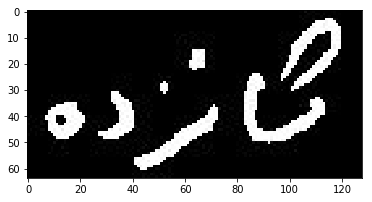

Prediction:           آراد[UNK]


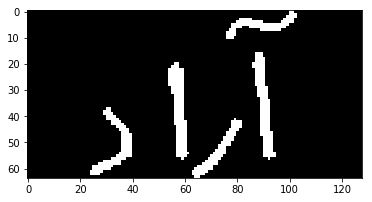

Prediction:          فرودون


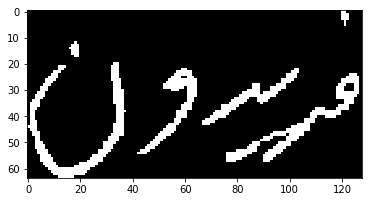

Prediction:            آبان


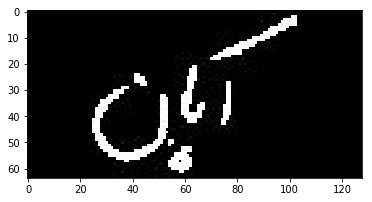

Prediction:            تمام


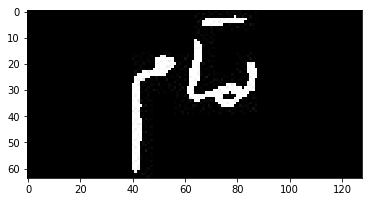

Prediction:            تلفن


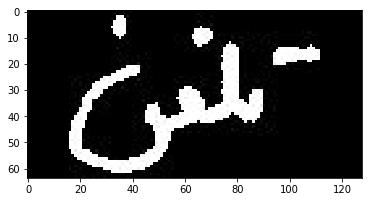

Prediction:            محرم


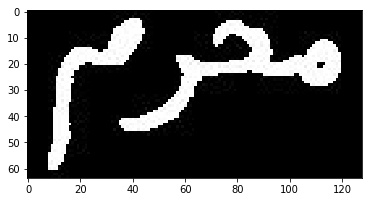

In [94]:
max_length = 15
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)


    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        title = f"Prediction: {pred_texts[i]}"
        print(title)
        plt.imshow(img, cmap="gray")
        plt.show()


In [95]:
model.save_weights('model4.h5')

In [96]:
data_dir = Path("./data/processed_cities")
files = sorted(list(map(str, list(data_dir.glob("*.tif")))))

Prediction:           سرزان


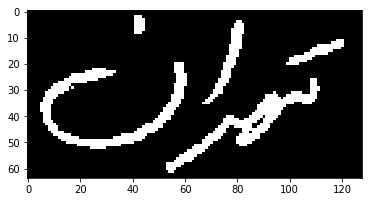

Prediction:            تورج


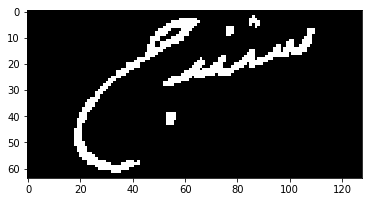

Prediction:          ببرزاد


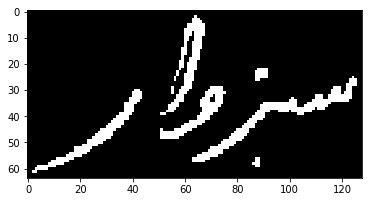

Prediction:          پريقد[UNK]


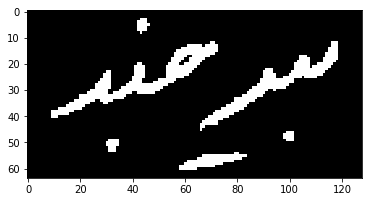

Prediction:           محتمد


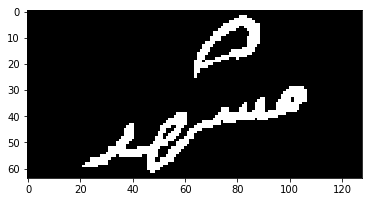

Prediction:           شاهور


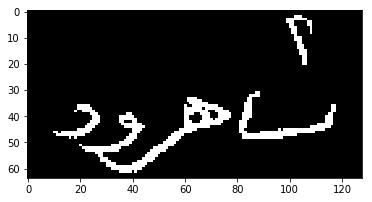

Prediction:           كرون[UNK]


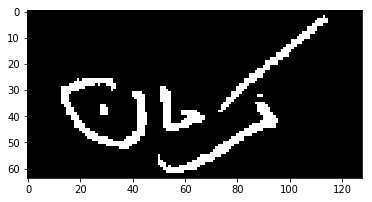

Prediction:           تبزين


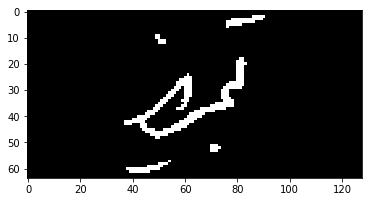

Prediction:          قهومان


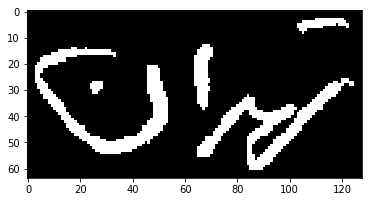

Prediction:           م تمه


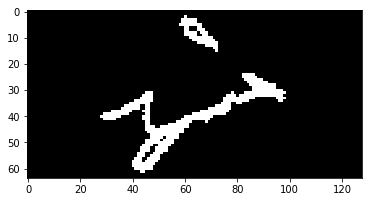

Prediction:           بعرزي


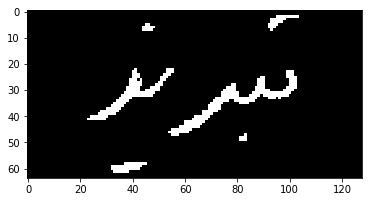

Prediction:           اهواز


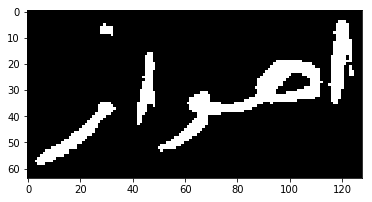

Prediction:           شيزاز


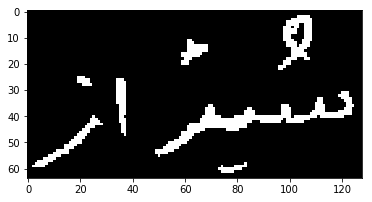

Prediction:          افهغان


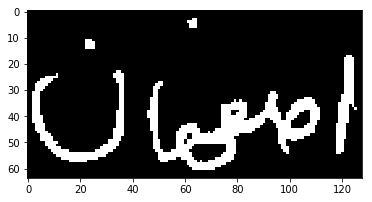

Prediction:          مهران[UNK]


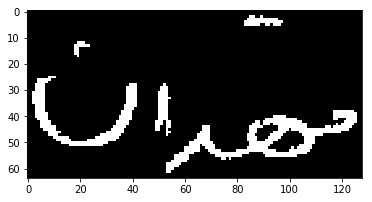

Prediction:           مهران


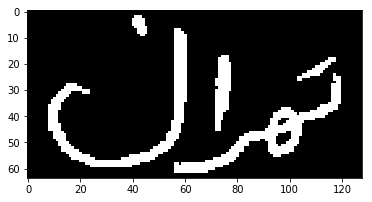

Prediction:           ككاين


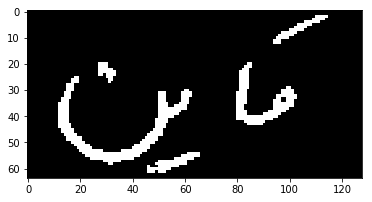

Prediction:       شيير هانو


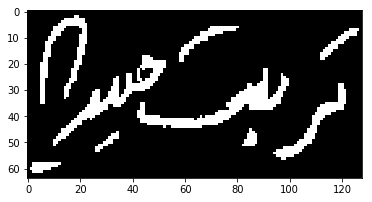

Prediction:            کاي[UNK]


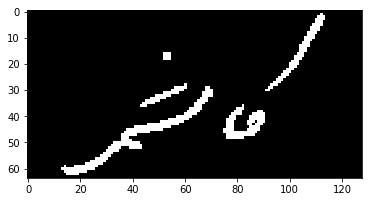

Prediction:           برگنش


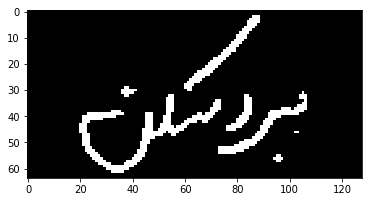

Prediction:           معتمد


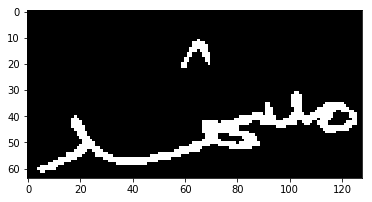

Prediction:           شيزاد


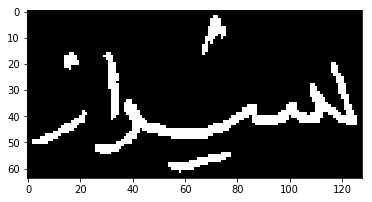

Prediction:            برود


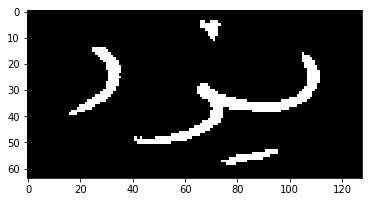

Prediction:          ااسانه


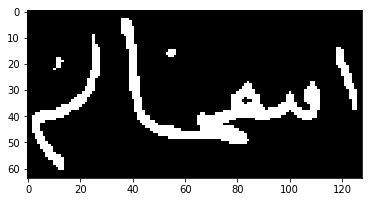

Prediction:             ريم


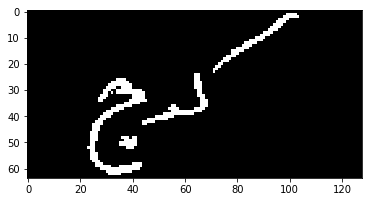

Prediction:          شهيزاز


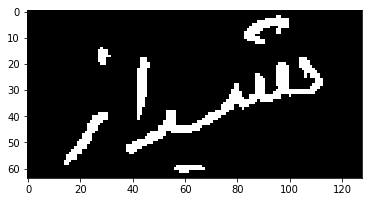

Prediction:           محنمر


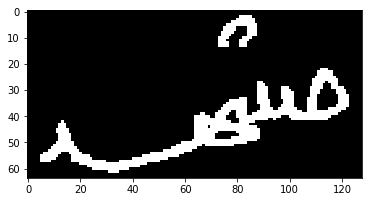

Prediction:           قهمان


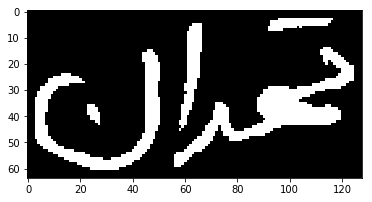

Prediction:            هتم[UNK]


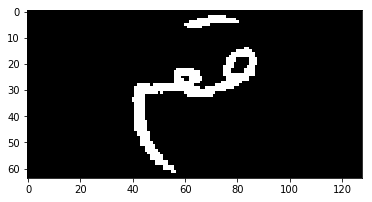

Prediction:           يانبر


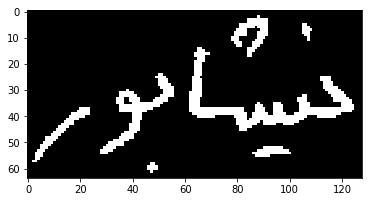

Prediction:           مهماد


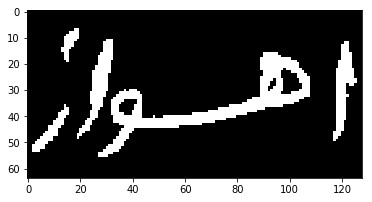

Prediction:           مهشمد


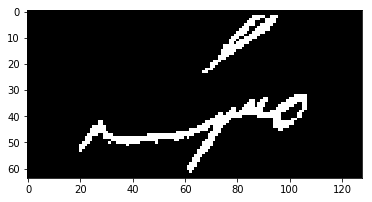

Prediction:           بيينه


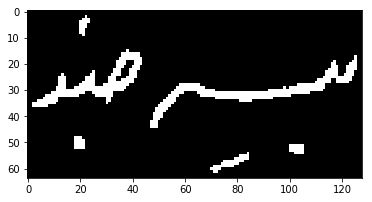

Prediction:           ككمان


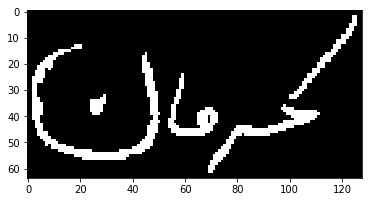

Prediction:           يييت[UNK]


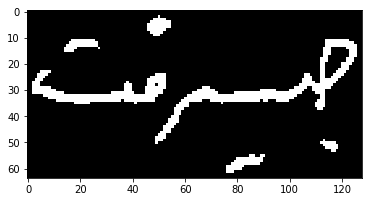

Prediction:           پريند


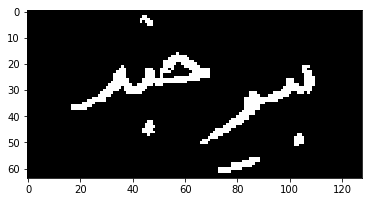

Prediction:           بهنود


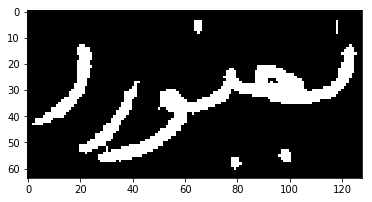

Prediction:            ششمه


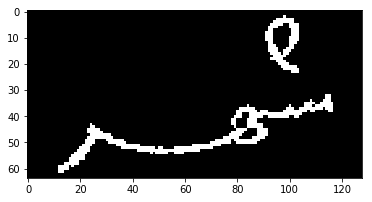

Prediction:        شاامپور[UNK]


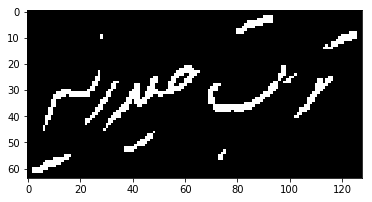

Prediction:            عبلي


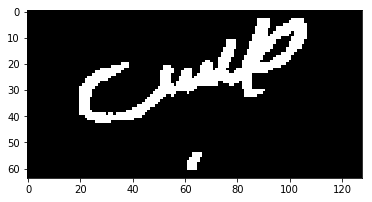

Prediction:             شله


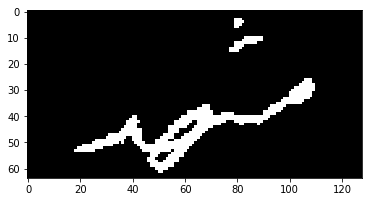

Prediction:            بروا


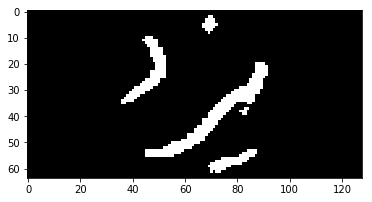

Prediction:           سنمان


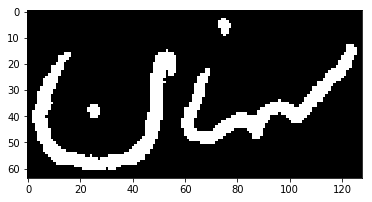

Prediction:           شهران


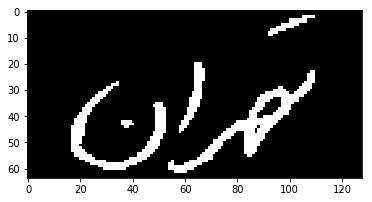

Prediction:          يرزيد[UNK]


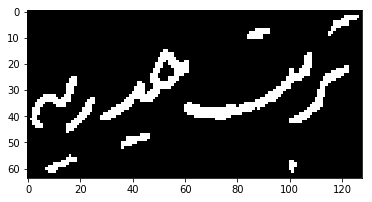

Prediction:          سرزان[UNK]


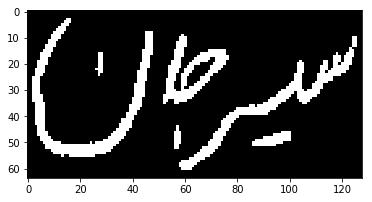

Prediction:          خرادان


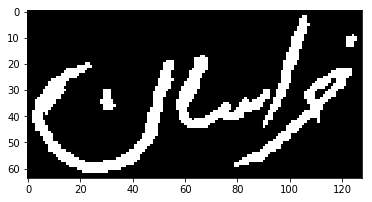

Prediction:           شيرزا


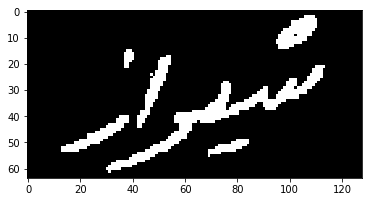

Prediction:           اسان[UNK]


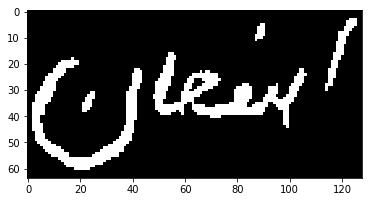

Prediction:           تهرن[UNK]


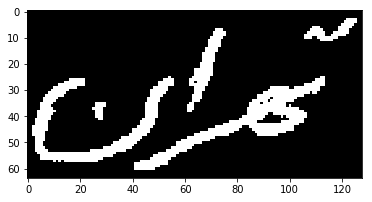

Prediction:          خادوان


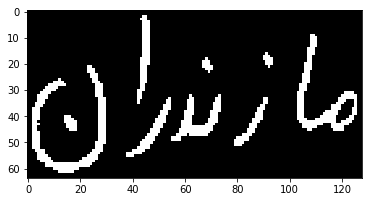

Prediction:           سرمان


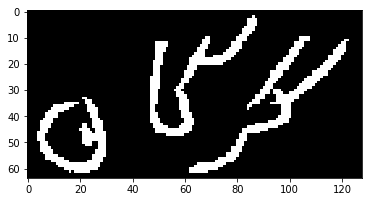

Prediction:           رامغا


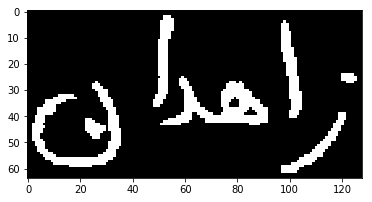

Prediction:            سارق


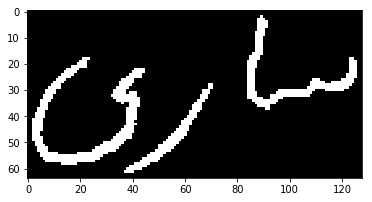

Prediction:            محت 


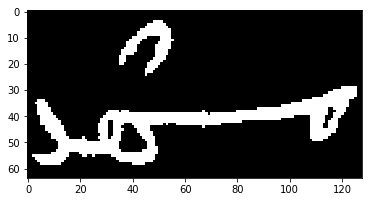

Prediction:           شهيار


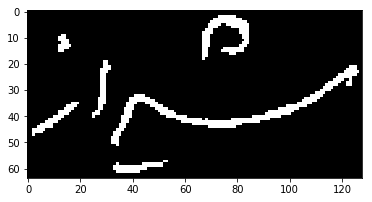

Prediction:           تيرير


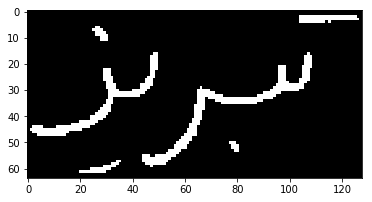

Prediction:           ميمان


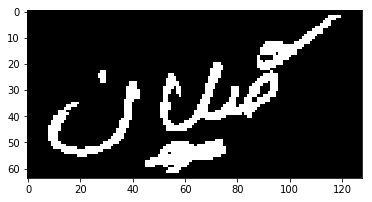

Prediction:          افمغان


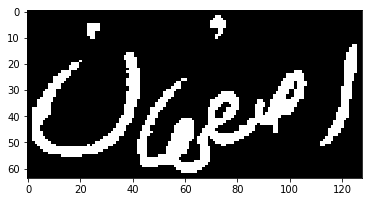

Prediction:           كهوان


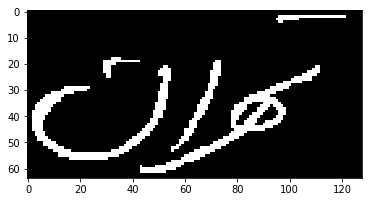

Prediction:           شيزاز


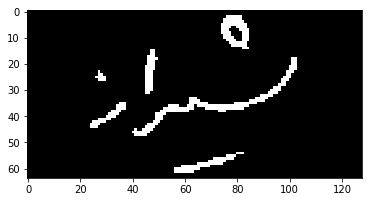

Prediction:           ببويز


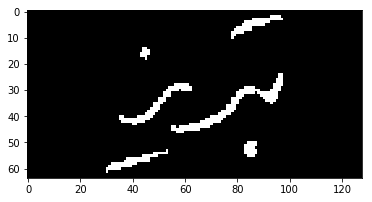

Prediction:            حت [UNK]


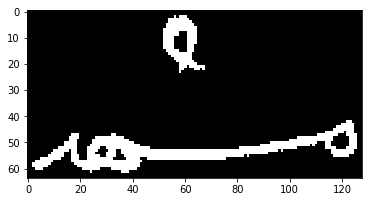

Prediction:           افلان


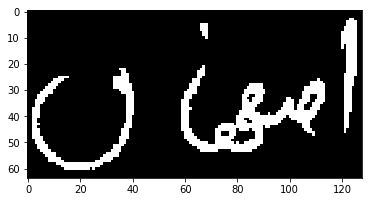

Prediction:           گتران


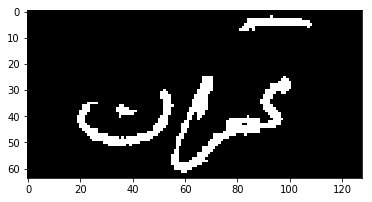

Prediction:            سمان


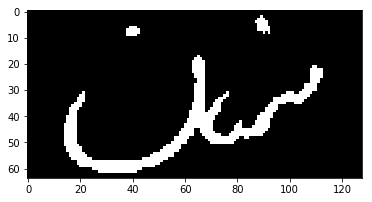

Prediction:           شيرنا


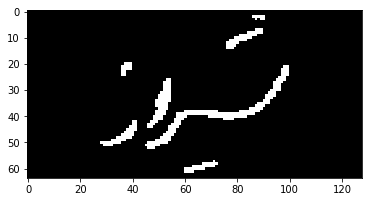

Prediction:           رسغنف


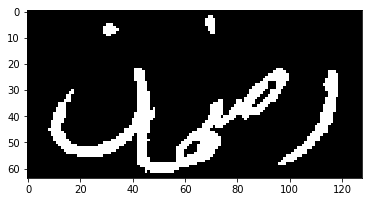

Prediction:           پررين


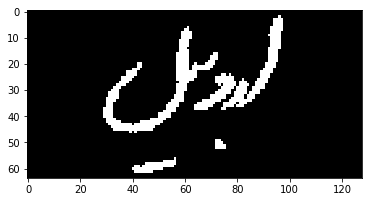

Prediction:            شثمه


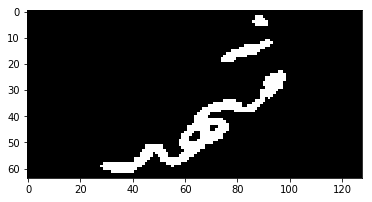

Prediction:           آبرين


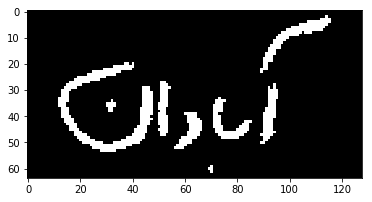

Prediction:            بباس


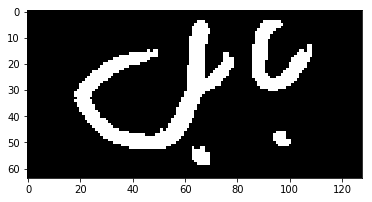

Prediction:           شهرزا


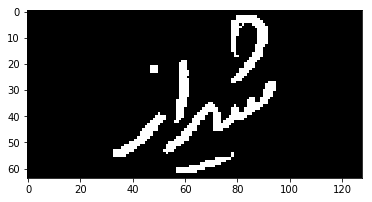

Prediction:           كرران


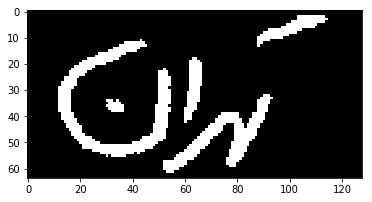

Prediction:           ممشند


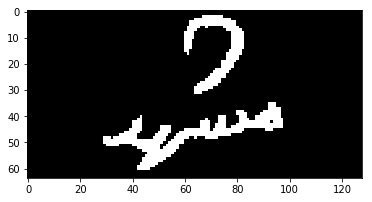

Prediction:           پييند


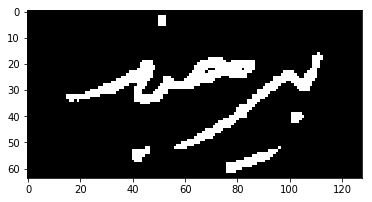

Prediction:            ساري


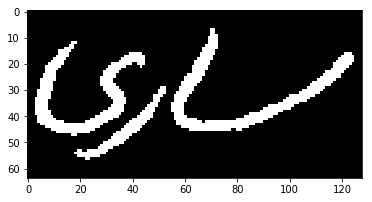

Prediction:            لوکش


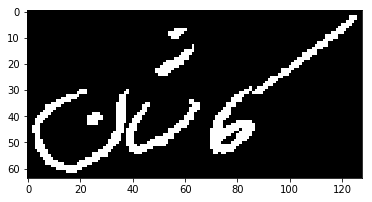

Prediction:           ترزان


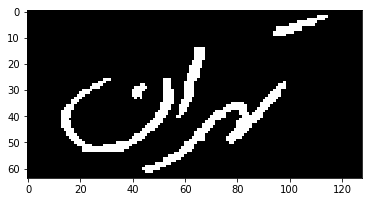

Prediction:          افسوان


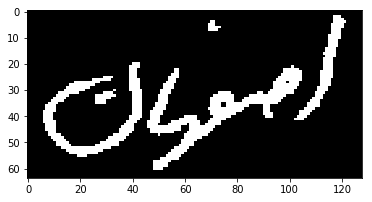

Prediction:          همامان


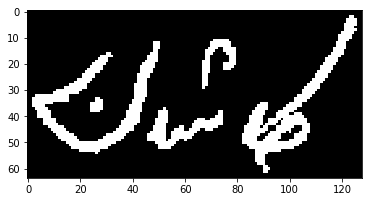

Prediction:           پريته


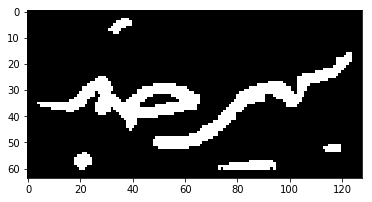

Prediction:           درداد


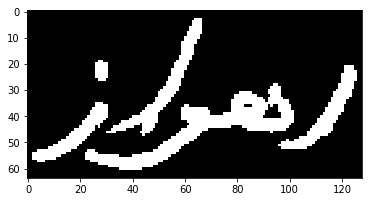

Prediction:            وششت


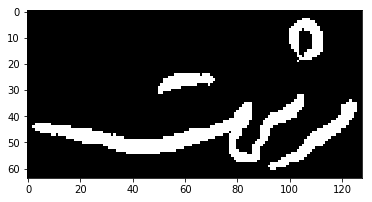

Prediction:          ارمشان


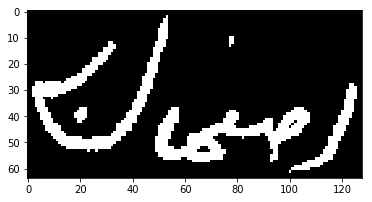

Prediction:           راور[UNK]


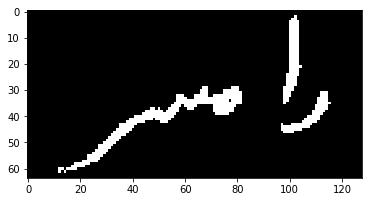

Prediction:           مهزان


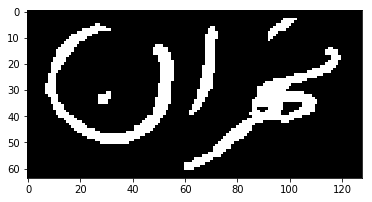

Prediction:             خهم


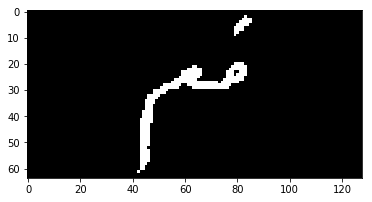

Prediction:           ممتمد


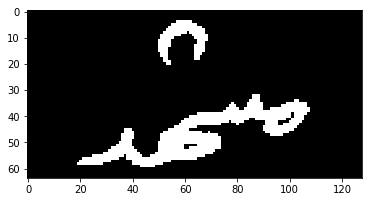

Prediction:           پهيند


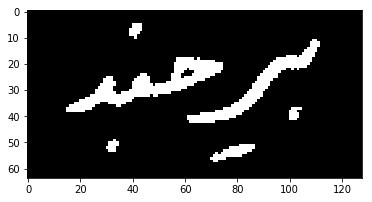

Prediction:          پريمان


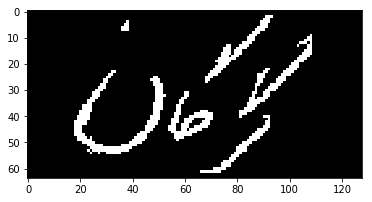

Prediction:             نر[UNK]


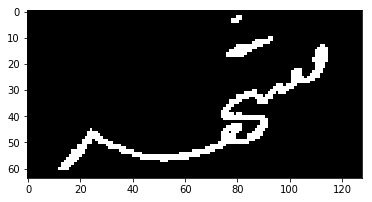

Prediction:           شيزاز


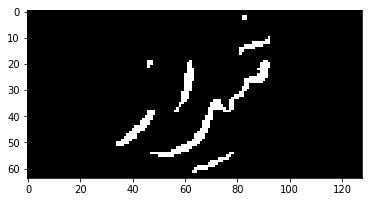

Prediction:           بريام


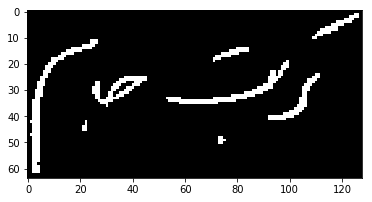

Prediction:          كريار[UNK]


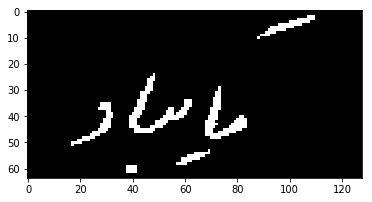

Prediction:          ككمان[UNK]


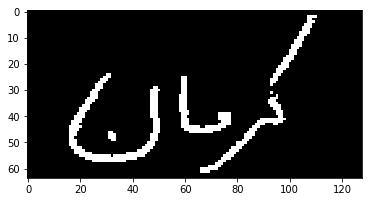

Prediction:            كورن


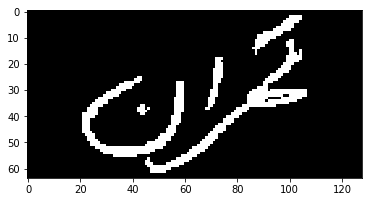

Prediction:            برزو


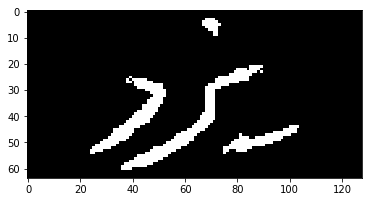

Prediction:            شيزا


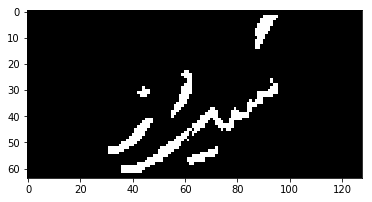

Prediction:           اففشا


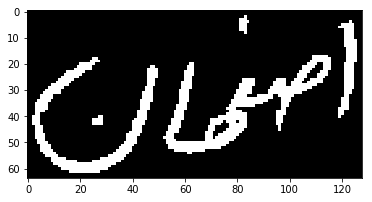

In [97]:
for file in files[:100]:
    img = Image.open(file).convert('L').resize((img_width,img_height))
        
    img = np.asarray(img,dtype='float32')
    img = img / 255.0
    img = img.reshape((img_height, img_width,1))
#     img = tf.convert_to_tensor(img, dtype=tf.float32)
    
    preds = prediction_model.predict(img.reshape((1,64,128,1)))
    pred_texts = decode_batch_predictions(preds)
    
    img = (img.reshape((64,128)) * 255).astype(np.uint8)
    title = f"Prediction: {pred_texts[0]}"
    print(title)
    plt.imshow(img, cmap="gray")
    plt.show()